In [78]:
import numpy as np
import pandas as pd
from dateutil.parser import parse
import pysal as ps
import geopandas as gpd
from geopy.distance import vincenty

### Read in training and test data
Keep only columns in training data that are present in test data

In [79]:
train = pd.read_csv('nmo-distilled-data/train-traps-nmo.csv')

In [80]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4616 entries, 0 to 4615
Data columns (total 14 columns):
Unnamed: 0         4616 non-null int64
trap-date          4616 non-null object
trap               4616 non-null object
num-sqitos         4616 non-null int64
ERRATICUS          4616 non-null int64
PIPIENS            4616 non-null int64
PIPIENSRESTUANS    4616 non-null int64
RESTUANS           4616 non-null int64
SALINARIUS         4616 non-null int64
TARSALIS           4616 non-null int64
TERRITANS          4616 non-null int64
wnv                4616 non-null int64
trap-lat           4616 non-null float64
trap-long          4616 non-null float64
dtypes: float64(2), int64(10), object(2)
memory usage: 505.0+ KB


In [81]:
train.head(2)

,Unnamed: 0,trap-date,trap,num-sqitos,ERRATICUS,PIPIENS,PIPIENSRESTUANS,RESTUANS,SALINARIUS,TARSALIS,TERRITANS,wnv,trap-lat,trap-long
0,0,2007-05-29,T002,2,0,0,1,1,0,0,0,0,41.954690,-87.800991
1,2,2007-05-29,T007,1,0,0,0,1,0,0,0,0,41.994991,-87.769279


In [82]:
test = pd.read_csv('nmo-distilled-data/test-traps-nmo.csv')

In [83]:
test.head()

,Unnamed: 0,test-date,trap,test-lat,test-long,CULEX,ERRATICUS,PIPIENS,PIPENSRESTUANS,RESTUANS,SALINARIUS,TARSALIS,TERRITANS
0,0,2008-06-11,T001,41.953705,-87.733974,1,1,1,1,1,1,1,1
1,1,2008-06-11,T002,41.954690,-87.800991,1,1,1,1,1,1,1,1
2,2,2008-06-11,T002A,41.965571,-87.781978,1,1,1,1,1,1,1,1
3,3,2008-06-11,T002B,41.951878,-87.789234,1,1,1,1,1,1,1,1
4,4,2008-06-11,T003,41.964242,-87.757639,1,1,1,1,1,1,1,1


In [84]:
possible_columns = [col for col in test.columns if col in train.columns]

In [85]:
possible_columns

['Unnamed: 0',
 'trap',
 'ERRATICUS',
 'PIPIENS',
 'RESTUANS',
 'SALINARIUS',
 'TARSALIS',
 'TERRITANS']

In [86]:
train = train[possible_columns + ['PIPIENSRESTUANS', 'wnv', 'trap-date', 'trap-lat', 'trap-long']]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4616 entries, 0 to 4615
Data columns (total 13 columns):
Unnamed: 0         4616 non-null int64
trap               4616 non-null object
ERRATICUS          4616 non-null int64
PIPIENS            4616 non-null int64
RESTUANS           4616 non-null int64
SALINARIUS         4616 non-null int64
TARSALIS           4616 non-null int64
TERRITANS          4616 non-null int64
PIPIENSRESTUANS    4616 non-null int64
wnv                4616 non-null int64
trap-date          4616 non-null object
trap-lat           4616 non-null float64
trap-long          4616 non-null float64
dtypes: float64(2), int64(9), object(2)
memory usage: 468.9+ KB


In [87]:
train.head(2)

,Unnamed: 0,trap,ERRATICUS,PIPIENS,RESTUANS,SALINARIUS,TARSALIS,TERRITANS,PIPIENSRESTUANS,wnv,trap-date,trap-lat,trap-long
0,0,T002,0,0,1,0,0,0,1,0,2007-05-29,41.954690,-87.800991
1,2,T007,0,0,1,0,0,0,0,0,2007-05-29,41.994991,-87.769279


In [88]:
del train['Unnamed: 0']

### Read in weather data

In [89]:
weather = pd.read_csv('nmo-distilled-data/weather-nmo.csv')

In [90]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 18 columns):
Unnamed: 0     2944 non-null int64
Station        2944 non-null int64
Date           2944 non-null object
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null float64
DewPoint       2944 non-null int64
WetBulb        2944 non-null float64
CodeSum        2944 non-null object
SnowFall       2944 non-null float64
PrecipTotal    2944 non-null float64
StnPressure    2944 non-null float64
SeaLevel       2944 non-null float64
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null float64
Lat            2944 non-null float64
Long           2944 non-null float64
dtypes: float64(10), int64(6), object(2)
memory usage: 414.1+ KB


In [91]:
del weather['Unnamed: 0']

In [92]:
weather.head(2)

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Lat,Long
0,1,2007-05-01,83,50,67.0,51,56.0,,0.0,0.0,29.10,29.82,1.7,27,9.2,41.995,-87.933
1,2,2007-05-01,84,52,68.0,51,57.0,,0.0,0.0,29.18,29.82,2.7,25,9.6,41.786,-87.752


### Read in spray data

In [93]:
spray = pd.read_csv('nmo-distilled-data/spray-nmo.csv')

In [94]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 5 columns):
Unnamed: 0    14835 non-null int64
spray-date    14835 non-null object
spray-time    14251 non-null object
spray-lat     14835 non-null float64
spray-long    14835 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 579.6+ KB


In [95]:
spray.head(2)

,Unnamed: 0,spray-date,spray-time,spray-lat,spray-long
0,0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,1,2011-08-29,6:57:08 PM,42.391348,-88.089163


In [96]:
del spray['Unnamed: 0']

### Merge data based on date and latitute and longitude for weather

In [97]:
weather = weather.rename(columns = {'Lat':'Latitude', 'Long':'Longitude'})
train = train.rename(columns = {'trap-lat':'Latitude', 'trap-long':'Longitude', 'trap-date':'Date'})
spray = spray.rename(columns = {'spray-lat':'Latitude', 'spray-long':'Longitude', 'spray-date':'Date'})

train['Date'] = train['Date'].apply(lambda x: parse(x).strftime('%Y-%m-%d'))
weather['Date'] = weather['Date'].apply(lambda x: parse(x).strftime('%Y-%m-%d'))
spray['Date'] = spray['Date'].apply(lambda x: parse(x).strftime('%Y-%m-%d'))

train['Latitude'] = train['Latitude'].round(3)
weather['Latitude'] = weather['Latitude'].round(3)
spray['Latitude'] = spray['Latitude'].round(3)

train['Longitude'] = train['Longitude'].round(3)
weather['Longitude'] = weather['Longitude'].round(3)
spray['Longitude'] = spray['Longitude'].round(3)

For each location in the training data, find the nearest observation

In [98]:
def nearest_observation(df, obs_col, latitude, longitude):
    
    # distance in miles from the geopy package
    def dist(lat1, long1, lat2, long2):
        return vincenty((lat1, long1), (lat2, long2)).miles

    # get the min distance and station relative to the input lat/long
    distances = df.apply(lambda row: dist(latitude, longitude, row['Latitude'], row['Longitude']), axis=1)
    return min(distances), df.loc[distances.idxmin(), obs_col]

In [99]:
train_locs = train[['Latitude', 'Longitude']].drop_duplicates()
station_locs = weather[['Station', 'Latitude', 'Longitude']].drop_duplicates()
train_locs['Min_Station_Distance'] = None
train_locs['Closest_Station'] = None
print(len(train_locs), len(station_locs))

138 2


In [100]:
train_locs.head()

,Latitude,Longitude,Min_Station_Distance,Closest_Station
0,41.955,-87.801,None,None
1,41.995,-87.769,None,None
2,41.974,-87.825,None,None
3,41.922,-87.666,None,None
4,41.891,-87.654,None,None


In [101]:
for i, row in train_locs.iterrows():
    dist, station = nearest_observation(station_locs, 'Station', row['Latitude'], row['Longitude'])
    train_locs.loc[i, 'Min_Station_Distance'] = dist
    train_locs.loc[i, 'Closest_Station'] = station

In [102]:
train_locs.head()

,Latitude,Longitude,Min_Station_Distance,Closest_Station
0,41.955,-87.801,7.33733,1
1,41.995,-87.769,8.44356,1
2,41.974,-87.825,5.74707,1
3,41.922,-87.666,10.3823,2
4,41.891,-87.654,8.83721,2


In [103]:
# merge location data
train = train.merge(train_locs, on=['Latitude', 'Longitude'], how='left')

In [104]:
train.head()

,trap,ERRATICUS,PIPIENS,RESTUANS,SALINARIUS,TARSALIS,TERRITANS,PIPIENSRESTUANS,wnv,Date,Latitude,Longitude,Min_Station_Distance,Closest_Station
0,T002,0,0,1,0,0,0,1,0,2007-05-29,41.955,-87.801,7.33733,1
1,T007,0,0,1,0,0,0,0,0,2007-05-29,41.995,-87.769,8.44356,1
2,T015,0,0,1,0,0,0,1,0,2007-05-29,41.974,-87.825,5.74707,1
3,T045,0,0,1,0,0,0,0,0,2007-05-29,41.922,-87.666,10.3823,2
4,T046,0,0,1,0,0,0,0,0,2007-05-29,41.891,-87.654,8.83721,2


In [105]:
# merge weather data on date and closest station
train = train.merge(weather, left_on=['Date', 'Closest_Station'], right_on=['Date', 'Station'], how='left')

In [106]:
train.columns

Index(['trap', 'ERRATICUS', 'PIPIENS', 'RESTUANS', 'SALINARIUS', 'TARSALIS',
       'TERRITANS', 'PIPIENSRESTUANS', 'wnv', 'Date', 'Latitude_x',
       'Longitude_x', 'Min_Station_Distance', 'Closest_Station', 'Station',
       'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'CodeSum', 'SnowFall',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'Latitude_y', 'Longitude_y'],
      dtype='object')

In [107]:
del train['Latitude_y']
del train['Longitude_y']

In [108]:
train=train.rename(columns = {'Latitude_x':'Latitude', 'Longitude_x':'Longitude'})

In [109]:
train.head()

,trap,ERRATICUS,PIPIENS,RESTUANS,SALINARIUS,TARSALIS,TERRITANS,PIPIENSRESTUANS,wnv,Date,...,DewPoint,WetBulb,CodeSum,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,T002,0,0,1,0,0,0,1,0,2007-05-29,...,58,65.0,BR HZ,0.0,0.0,29.39,30.11,5.8,18,6.5
1,T007,0,0,1,0,0,0,0,0,2007-05-29,...,58,65.0,BR HZ,0.0,0.0,29.39,30.11,5.8,18,6.5
2,T015,0,0,1,0,0,0,1,0,2007-05-29,...,58,65.0,BR HZ,0.0,0.0,29.39,30.11,5.8,18,6.5
3,T045,0,0,1,0,0,0,0,0,2007-05-29,...,59,66.0,BR HZ,0.0,0.0,29.44,30.09,5.8,16,7.4
4,T046,0,0,1,0,0,0,0,0,2007-05-29,...,59,66.0,BR HZ,0.0,0.0,29.44,30.09,5.8,16,7.4


### Merge spray data based on latitude and longitude; code 1 if spray occurred within 5 miles

In [110]:
spray_locs = spray[['Latitude', 'Longitude']].drop_duplicates()
spray_locs.reset_index(inplace=True) # create unique id
spray_locs.columns = ['UID', 'Latitude', 'Longitude']
print(len(spray_locs))
spray_locs.head()

6517


,UID,Latitude,Longitude
0,0,42.392,-88.089
1,1,42.391,-88.089
2,4,42.390,-88.089
3,5,42.390,-88.088
4,6,42.391,-88.088


In [111]:
# add unique id to spray data for later merging
spray = spray.merge(spray_locs, on=['Latitude', 'Longitude'], how='left')
spray.head()

,Date,spray-time,Latitude,Longitude,UID
0,2011-08-29,6:56:58 PM,42.392,-88.089,0
1,2011-08-29,6:57:08 PM,42.391,-88.089,1
2,2011-08-29,6:57:18 PM,42.391,-88.089,1
3,2011-08-29,6:57:28 PM,42.391,-88.089,1
4,2011-08-29,6:57:38 PM,42.390,-88.089,4


In [112]:
train_locs['Min_Spray_Distance'] = None
train_locs['Closest_Spray'] = None
train_locs.head()

,Latitude,Longitude,Min_Station_Distance,Closest_Station,Min_Spray_Distance,Closest_Spray
0,41.955,-87.801,7.33733,1,None,None
1,41.995,-87.769,8.44356,1,None,None
2,41.974,-87.825,5.74707,1,None,None
3,41.922,-87.666,10.3823,2,None,None
4,41.891,-87.654,8.83721,2,None,None


In [113]:
for i, row in train_locs.iterrows():
    dist, spray_uid = nearest_observation(spray_locs, 'UID', row['Latitude'], row['Longitude'])
    train_locs.loc[i, 'Min_Spray_Distance'] = dist
    train_locs.loc[i, 'Closest_Spray'] = spray_uid

In [114]:
# merge back to full spray data on the unique id we created
spray = spray.merge(train_locs, left_on='UID', right_on='Closest_Spray', how='left')
spray.head()

,Date,spray-time,Latitude_x,Longitude_x,UID,Latitude_y,Longitude_y,Min_Station_Distance,Closest_Station,Min_Spray_Distance,Closest_Spray
0,2011-08-29,6:56:58 PM,42.392,-88.089,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-08-29,6:57:08 PM,42.391,-88.089,1,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-08-29,6:57:18 PM,42.391,-88.089,1,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-08-29,6:57:28 PM,42.391,-88.089,1,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-08-29,6:57:38 PM,42.390,-88.089,4,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
# subset only to those data with distances less than 5
spray = spray[spray['Min_Spray_Distance'] <= 5]
print(len(spray))
spray.head()

232


,Date,spray-time,Latitude_x,Longitude_x,UID,Latitude_y,Longitude_y,Min_Station_Distance,Closest_Station,Min_Spray_Distance,Closest_Spray
115,2011-09-07,7:57:22 PM,41.970,-87.788,115,41.970,-87.788,7.66357,1,0,115
116,2011-09-07,7:57:32 PM,41.970,-87.788,115,41.970,-87.788,7.66357,1,0,115
406,2011-09-07,8:57:52 PM,41.974,-87.805,406,41.974,-87.805,6.74865,1,0,406
407,2011-09-07,8:58:02 PM,41.974,-87.805,406,41.974,-87.805,6.74865,1,0,406
1051,2011-09-07,NaN,41.990,-87.797,1051,41.990,-87.797,7.01075,1,0,1051


In [116]:
# clean up column names for clarity
spray=spray.rename(columns = {'Latitude_x':'Latitude', 'Longitude_x':'Longitude', 
                             'Latitude_y':'Latitude_train', 'Longitude_y':'Longitude_train'})

In [117]:
train.columns

Index(['trap', 'ERRATICUS', 'PIPIENS', 'RESTUANS', 'SALINARIUS', 'TARSALIS',
       'TERRITANS', 'PIPIENSRESTUANS', 'wnv', 'Date', 'Latitude', 'Longitude',
       'Min_Station_Distance', 'Closest_Station', 'Station', 'Tmax', 'Tmin',
       'Tavg', 'DewPoint', 'WetBulb', 'CodeSum', 'SnowFall', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [118]:
spray.columns

Index(['Date', 'spray-time', 'Latitude', 'Longitude', 'UID', 'Latitude_train',
       'Longitude_train', 'Min_Station_Distance', 'Closest_Station',
       'Min_Spray_Distance', 'Closest_Spray'],
      dtype='object')

In [119]:
train = train.merge(spray[['Date', 'Latitude_train', 'Longitude_train', 'Min_Spray_Distance']], 
                    left_on=['Date', 'Latitude', 'Longitude'], right_on=['Date', 'Latitude_train', 'Longitude_train'], 
                    how='left')

In [120]:
del train['Latitude_train']
del train['Longitude_train']

In [121]:
# Where Min_Spray_Distance is null, a spray did not occur
train['Spray'] = 0
train.loc[train['Min_Spray_Distance'].notnull(), 'Spray'] = 1

In [122]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4648 entries, 0 to 4647
Data columns (total 30 columns):
trap                    4648 non-null object
ERRATICUS               4648 non-null int64
PIPIENS                 4648 non-null int64
RESTUANS                4648 non-null int64
SALINARIUS              4648 non-null int64
TARSALIS                4648 non-null int64
TERRITANS               4648 non-null int64
PIPIENSRESTUANS         4648 non-null int64
wnv                     4648 non-null int64
Date                    4648 non-null object
Latitude                4648 non-null float64
Longitude               4648 non-null float64
Min_Station_Distance    4648 non-null object
Closest_Station         4648 non-null object
Station                 4648 non-null int64
Tmax                    4648 non-null int64
Tmin                    4648 non-null int64
Tavg                    4648 non-null float64
DewPoint                4648 non-null int64
WetBulb                 4648 non-null float64
C

In [123]:
train.head(2)

,trap,ERRATICUS,PIPIENS,RESTUANS,SALINARIUS,TARSALIS,TERRITANS,PIPIENSRESTUANS,wnv,Date,...,CodeSum,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Min_Spray_Distance,Spray
0,T002,0,0,1,0,0,0,1,0,2007-05-29,...,BR HZ,0.0,0.0,29.39,30.11,5.8,18,6.5,NaN,0
1,T007,0,0,1,0,0,0,0,0,2007-05-29,...,BR HZ,0.0,0.0,29.39,30.11,5.8,18,6.5,NaN,0


In [124]:
train.to_csv('full_training_data.csv', index=False)

### Spatial regression

In [125]:
train.columns

Index(['trap', 'ERRATICUS', 'PIPIENS', 'RESTUANS', 'SALINARIUS', 'TARSALIS',
       'TERRITANS', 'PIPIENSRESTUANS', 'wnv', 'Date', 'Latitude', 'Longitude',
       'Min_Station_Distance', 'Closest_Station', 'Station', 'Tmax', 'Tmin',
       'Tavg', 'DewPoint', 'WetBulb', 'CodeSum', 'SnowFall', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'Min_Spray_Distance', 'Spray'],
      dtype='object')

In [143]:
# Variables for baseline regression
X_vars = ['Tavg', 'DewPoint', 'WetBulb', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'AvgSpeed', 'Spray', 
     'ERRATICUS', 'PIPIENS', 'RESTUANS', 'SALINARIUS', 'TARSALIS', 'TERRITANS', 'PIPIENSRESTUANS']

In [144]:
train_reg_df = train[X_vars + ['wnv', 'Latitude', 'Longitude', 'Date']].dropna().reset_index()

In [145]:
X = train_reg_df[X_vars]
y = train_reg_df['wnv']

In [146]:
# This is time series data, so there are repeated observations of the same places, we want to build spatial weights
# from nearest neighbors, not repeated observations of the same place

In [147]:
unique_locs = train_reg_df[['Longitude', 'Latitude']].drop_duplicates().reset_index()
unique_locs.head()

,index,Longitude,Latitude
0,0,-87.801,41.955
1,1,-87.769,41.995
2,2,-87.825,41.974
3,3,-87.666,41.922
4,4,-87.654,41.891


In [148]:
# Create weights that link each data point to its 5 nearest neighbors to weight for the influence of nearby areas
w = ps.knnW_from_array(unique_locs[['Longitude', 'Latitude']].values, k=5)
w.transform = 'R' # row standardization
w

In [149]:
from collections import defaultdict

In [150]:
# create a new dictionary for weights for the full data where for each observation it lists the nearest observations
# on the day of the observation
full_weights = {}
for location_idx, neighbors in w:
    # lat and long of current location in small weights
    location = (unique_locs.iloc[location_idx]['Latitude'].item(), 
                unique_locs.iloc[location_idx]['Longitude'].item())
    
    # locations of its neighbors
    nn_locs = []
    for neighbor_idx in neighbors:
        nn_locs.append((unique_locs.iloc[neighbor_idx]['Latitude'].item(), 
                        unique_locs.iloc[neighbor_idx]['Longitude'].item())) 
    
    # observations in the full data where the location matches the current location
    location_obs = train_reg_df[(train_reg_df['Latitude']==location[0]) & (train_reg_df['Longitude']==location[1])]
    for i, location_ob in location_obs.iterrows():  
        date = location_ob['Date']
        nns = []
        for nn_loc in nn_locs:
            # observations with the same location and date
            neighbor_obs = \
                train_reg_df[(train_reg_df['Latitude']==nn_loc[0]) & (train_reg_df['Longitude']==nn_loc[1]) \
                            & (train_reg_df['Date']==date)] \
                .index.tolist()
            nns += neighbor_obs  
        full_weights[i] = list(set(nns))

In [151]:
len(full_weights) == len(train_reg_df)

True

In [152]:
w2 = ps.weights.weights.W(full_weights, silent_island_warning=True)
w2.transform = 'R' # row standardization
w2

In [166]:
len(list(w2))

4648

In [167]:
len(train)

4648

In [168]:
train.head()

,trap,ERRATICUS,PIPIENS,RESTUANS,SALINARIUS,TARSALIS,TERRITANS,PIPIENSRESTUANS,wnv,Date,...,CodeSum,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Min_Spray_Distance,Spray
0,T002,0,0,1,0,0,0,1,0,2007-05-29,...,BR HZ,0.0,0.0,29.39,30.11,5.8,18,6.5,NaN,0
1,T007,0,0,1,0,0,0,0,0,2007-05-29,...,BR HZ,0.0,0.0,29.39,30.11,5.8,18,6.5,NaN,0
2,T015,0,0,1,0,0,0,1,0,2007-05-29,...,BR HZ,0.0,0.0,29.39,30.11,5.8,18,6.5,NaN,0
3,T045,0,0,1,0,0,0,0,0,2007-05-29,...,BR HZ,0.0,0.0,29.44,30.09,5.8,16,7.4,NaN,0
4,T046,0,0,1,0,0,0,0,0,2007-05-29,...,BR HZ,0.0,0.0,29.44,30.09,5.8,16,7.4,NaN,0


In [170]:
pd.DataFrame(list(w2))

,0,1
0,0,{}
1,1,{14: 1.0}
2,2,{0: 1.0}
3,3,"{6: 0.5, 7: 0.5}"
4,4,"{5: 0.5, 6: 0.5}"
5,5,"{10: 0.5, 4: 0.5}"
6,6,"{3: 0.3333333333333333, 4: 0.3333333333333333,..."
7,7,{3: 1.0}
8,8,"{3: 0.3333333333333333, 13: 0.3333333333333333..."
9,9,{11: 1.0}


In [164]:
list(w2)

[(0, {}),
 (1, {14: 1.0}),
 (2, {0: 1.0}),
 (3, {6: 0.5, 7: 0.5}),
 (4, {5: 0.5, 6: 0.5}),
 (5, {4: 0.5, 10: 0.5}),
 (6, {3: 0.3333333333333333, 4: 0.3333333333333333, 5: 0.3333333333333333}),
 (7, {3: 1.0}),
 (8, {3: 0.3333333333333333, 6: 0.3333333333333333, 13: 0.3333333333333333}),
 (9, {11: 1.0}),
 (10, {5: 1.0}),
 (11, {12: 1.0}),
 (12, {11: 0.5, 17: 0.5}),
 (13, {4: 0.5, 8: 0.5}),
 (14, {}),
 (15, {}),
 (16, {}),
 (17, {11: 1.0}),
 (18, {42: 1.0}),
 (19, {21: 0.5, 43: 0.5}),
 (20,
  {18: 0.3333333333333333, 19: 0.3333333333333333, 21: 0.3333333333333333}),
 (21,
  {18: 0.3333333333333333, 19: 0.3333333333333333, 20: 0.3333333333333333}),
 (22, {19: 0.5, 43: 0.5}),
 (23,
  {45: 0.3333333333333333, 46: 0.3333333333333333, 57: 0.3333333333333333}),
 (24, {41: 1.0}),
 (25,
  {47: 0.3333333333333333, 48: 0.3333333333333333, 57: 0.3333333333333333}),
 (26, {}),
 (27, {32: 0.5, 46: 0.5}),
 (28, {31: 0.5, 32: 0.5}),
 (29, {30: 0.25, 31: 0.25, 36: 0.25, 44: 0.25}),
 (30,
  {29: 0.3333333

In [153]:
# Basic linear model with the nearest neighbor weights
# pysal.spreg.OLS computes the regression coefficients and their standard errors, t-stats and p-values. 
# It also computes a large battery of diagnostics on the regression.
m_w = ps.spreg.OLS(y.values[:, None], X.values, w=w2, spat_diag=True, name_x=X_vars, name_y='WNVpresent')

In [163]:
help(ps.spreg)

Help on package pysal.spreg in pysal:

NAME
    pysal.spreg

PACKAGE CONTENTS
    diagnostics
    diagnostics_sp
    diagnostics_sur
    diagnostics_tsls
    error_sp
    error_sp_het
    error_sp_het_regimes
    error_sp_hom
    error_sp_hom_regimes
    error_sp_regimes
    ml_error
    ml_error_regimes
    ml_lag
    ml_lag_regimes
    ols
    ols_regimes
    opt
    probit
    regimes
    robust
    sputils
    summary_output
    sur
    sur_error
    sur_lag
    sur_utils
    twosls
    twosls_regimes
    twosls_sp
    twosls_sp_regimes
    user_output
    utils
    w_utils

SUBMODULES
    REGI
    SUMMARY
    USER
    UTILS

FILE
    /Users/nmolivo/anaconda/lib/python3.5/site-packages/pysal/spreg/__init__.py




In [154]:
print(m_w.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  WNVpresent                Number of Observations:        4648
Mean dependent var  :      0.1205                Number of Variables   :          17
S.D. dependent var  :      0.5262                Degrees of Freedom    :        4631
R-squared           :      0.3393
Adjusted R-squared  :      0.3370
Sum squared residual:     849.975                F-statistic           :    148.6579
Sigma-square        :       0.184                Prob(F-statistic)     :           0
S.E. of regression  :       0.428                Log likelihood        :   -2646.784
Sigma-square ML     :       0.183                Akaike info criterion :    5327.568
S.E of regression ML:      0.4276                Schwarz criterion     :    5437.119

-----------------------------------------------------------------------------

In [155]:
# The diagnostics for spatial dependence show that there is spatial dependence

In [156]:
# compare with just a basic model without weights
m_b = ps.spreg.OLS(y.values[:, None], X.values, w=None, name_x=X_vars, name_y='WNVpresent')

In [157]:
print(m_w.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  WNVpresent                Number of Observations:        4648
Mean dependent var  :      0.1205                Number of Variables   :          17
S.D. dependent var  :      0.5262                Degrees of Freedom    :        4631
R-squared           :      0.3393
Adjusted R-squared  :      0.3370
Sum squared residual:     849.975                F-statistic           :    148.6579
Sigma-square        :       0.184                Prob(F-statistic)     :           0
S.E. of regression  :       0.428                Log likelihood        :   -2646.784
Sigma-square ML     :       0.183                Akaike info criterion :    5327.568
S.E of regression ML:      0.4276                Schwarz criterion     :    5437.119

-----------------------------------------------------------------------------

In [158]:
from sklearn.metrics import mean_squared_error as mse

mses = pd.Series({'OLS': mse(y, m_b.predy.flatten()), 'OLS+W': mse(y, m_w.predy.flatten())})
mses.sort_values()

OLS      0.182869
OLS+W    0.182869
dtype: float64

In [159]:
# Hmm, need to work on this. But progress!

In [3]:
import pandas as pd

In [17]:
cities_info = bycities.groupby(['City']).first()
cities_info.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,Latitude,Longitude
City,,,,,,
Abidjan Côte D'Ivoire,1900-01-01,25.696,1.326,Côte D'Ivoire,5.63N,3.23W
Addis Abeba Ethiopia,1900-01-01,17.019,1.073,Ethiopia,8.84N,38.11E
Ahmadabad India,1900-01-01,18.814,0.685,India,23.31N,72.52E
Aleppo Syria,1900-01-01,6.023,0.604,Syria,36.17N,37.79E
Alexandria Egypt,1900-01-01,14.322,0.960,Egypt,31.35N,30.16E


In [18]:
def get_temp_markers(city_names, year):
    points = np.zeros(len(city_names), dtype=[('lon', float, 1),
                                      ('lat', float, 1),
                                      ('size',     float, 1),
                                      ('color',    float, 1)])
    cmap = plt.get_cmap('coolwarm')
    
    for i, city in enumerate(city_names):
        city_temps = city_means.loc[city]
        _MIN, _MAX, _MEDIAN = city_temps.min(), city_temps.max(), city_temps.median()
        temp = city_temps.loc[year]
        
        coords = cities_info.loc[city][['Latitude', 'Longitude']].values
        lat = float(coords[0][:-1]) * (-1 if coords[0][-1] == 'S' else 1)
        lon = float(coords[1][:-1]) * (-1 if coords[1][-1] == 'W' else 1)
        
        points['lat'][i] = lat
        points['lon'][i] = lon
        points['size'][i] = 100 * abs(temp - _MEDIAN)
        points['color'][i] = (temp - _MIN) / (_MAX - _MIN)
            
    return points 

In [19]:
bycities = pd.read_csv('GlobalLandTemperaturesByCity.csv', parse_dates=['dt'])
# there are some cities with the same name but in different countries 
bycities[['City', 'Country']].drop_duplicates()
bycities.City = bycities.City.str.cat(bycities.Country, sep=' ')
bycities = bycities[bycities.dt.dt.year >= 1900]

In [20]:
city_means = bycities.groupby(['City', bycities.dt.dt.year])['AverageTemperature'].mean().unstack()
city_mins = bycities.groupby(['City', bycities.dt.dt.year])['AverageTemperature'].min().unstack()
city_maxs = bycities.groupby(['City', bycities.dt.dt.year])['AverageTemperature'].max().unstack()
city_means.head()

dt,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
City,,,,,,,,,,,,,,,,,,,,,
Abidjan Côte D'Ivoire,26.118500,25.91825,25.589417,25.481750,25.236917,25.783083,26.075583,25.685083,25.796750,25.566083,...,26.986000,26.976583,26.988083,27.006833,26.944500,26.982000,27.445417,27.017583,26.766333,27.228500
Addis Abeba Ethiopia,17.311417,17.61125,17.224667,17.137500,17.200250,17.187667,17.113833,16.831583,17.163750,16.743167,...,18.292750,18.312833,18.427083,18.142583,18.165000,18.765333,18.298250,18.606750,18.448583,19.539000
Ahmadabad India,26.902667,26.83150,27.295833,26.276000,26.622250,26.236167,26.189083,26.363333,26.071167,26.049083,...,27.628333,26.828083,27.282833,27.511167,27.048500,28.095833,28.017833,27.290417,27.027250,27.608625
Aleppo Syria,17.582917,18.37025,17.577750,17.080750,16.946667,16.890667,16.934667,16.507583,16.716167,17.729583,...,18.145917,18.105667,18.166083,18.392167,18.590083,18.438083,19.979417,18.016583,18.691917,19.503625
Alexandria Egypt,20.726833,20.88525,20.410750,19.585417,19.778583,19.902917,20.145500,19.470667,19.395250,20.400750,...,21.064167,21.082333,21.148167,21.507750,21.739000,21.670500,22.459583,21.181500,21.552583,21.438500


In [21]:
random_cities = city_means.sample(n_cities).index

In [28]:
#plt.rcParams['animation.ffmpeg_path'] = '/opt/local/bin/ffmpeg'

#anim = animation.FuncAnimation(fig, animate, init_func=init, frames=200, interval=20, blit=True)

#FFwriter = animation.FFMpegWriter()
#anim.save('basic_animation.mp4', writer = FFwriter, fps=30, extra_args=['-vcodec', 'libx264'])

/Users/nmolivo/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/nmolivo/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/nmolivo/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/nmolivo/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


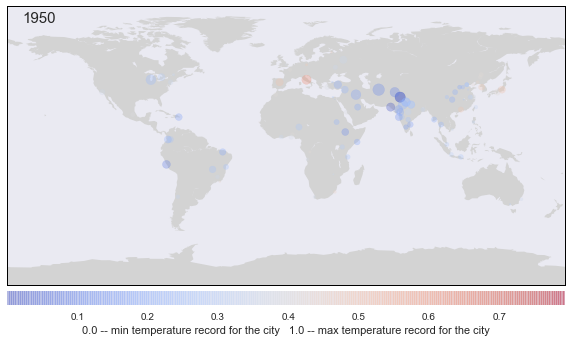

In [29]:

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
%matplotlib inline
 
# using Basemap for map visualization. Installed it with "conda install basemap"
from mpl_toolkits.basemap import Basemap
from matplotlib import animation, rc
from IPython.display import HTML
 
fig = plt.figure(figsize=(10, 10))
cmap = plt.get_cmap('coolwarm')
 
map = Basemap(projection='cyl')
map.drawmapboundary()
map.fillcontinents(color='lightgray', zorder=1)
 
START_YEAR = 1950
LAST_YEAR = 2013
 
n_cities = 100
random_cities = city_means.sample(n_cities).index
year_text = plt.text(-170, 80, str(START_YEAR),fontsize=15)
 
temp_markers = get_temp_markers(random_cities, START_YEAR)
xs, ys = map(temp_markers['lon'], temp_markers['lat'])
scat = map.scatter(xs, ys, s=temp_markers['size'], c=temp_markers['color'], cmap=cmap, marker='o', 
                   alpha=0.3, zorder=10)
 
def update(frame_number):
    current_year = START_YEAR + (frame_number % (LAST_YEAR - START_YEAR + 1))
     
    temp_markers = get_temp_markers(random_cities, current_year)
    xs, ys = map(temp_markers['lon'], temp_markers['lat'])
 
    scat.set_offsets(np.dstack((xs, ys)))
    scat.set_color(cmap(temp_markers['color']))
    scat.set_sizes(temp_markers['size'])
     
    year_text.set_text(str(current_year))
 
# Construct the animation, using the update function as the animation
# director.
ani = animation.FuncAnimation(fig, update, interval=500, frames=LAST_YEAR - START_YEAR + 1)
 
cbar = map.colorbar(scat, location='bottom')
cbar.set_label('0.0 -- min temperature record for the city   1.0 -- max temperature record for the city')

plt.show()


In [30]:
ani.save('animation.gif', writer='imagemagick', fps=2)

/Users/nmolivo/anaconda/lib/python3.5/site-packages/matplotlib/animation.py:1021: UserWarning: MovieWriter imagemagick unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


ValueError: Cannot save animation: no writers are available. Please install ffmpeg to save animations.